<a href="https://colab.research.google.com/github/MaryamFaramarzi/ProjectDSR29_medicalQA/blob/main/Image_retieval_flowers_optimized_Nyris_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount google drive


In [5]:
# Data is located is google drive /gdrive/MyDrive/Colab\ Notebooks/dataset/
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Colab\ Notebooks/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Colab Notebooks


In [ ]:
PATH_TRAIN = "dataset/train"
PATH_VALID = "dataset/valid"
n_pca_components = 100
max_num_images = 100

# Import libraries

In [6]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

# Necessary functionalities

In [7]:
# load the image
def load_image(path, model):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

def get_image_paths(images_path,image_extensions,max_num_images):
    images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
    if max_num_images < len(images):
        images = random.sample(images, max_num_images)
    print("keeping %d images to analyze" % len(images))
    return images

# calculate cosine similarity
def get_closest_images_cosine(new_pca_features, pca_features, num_results=5):
    distances = [distance.cosine(new_pca_features, feat) for feat in pca_features]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

# calculate k-NN
def get_closest_images_knn(new_pca_features, pca_features, num_results=5):
    neigh = NearestNeighbors(n_neighbors=num_results+1, metric='euclidean')
    neigh.fit(pca_features)
    distances, indexes = neigh.kneighbors([new_pca_features])
    idx_closest = indexes[0][1:]
    return idx_closest

# load the most similar images
def get_concatenated_images(indexes, images, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

# compute the features for images
def calculate_features(images,feat_extractor,model):
      features = []
      for i, image_path in enumerate(images):
          img, x = load_image(image_path, model)
          feat = feat_extractor.predict(x)[0]
          features.append(feat)
      features = np.array(features)
      return features


# Representation

In [8]:
# Load Images
images_path = PATH_TRAIN
image_extensions = ['.jpg', '.png', '.jpeg']
if not os.path.exists(images_path):
    raise ValueError("Dataset not found. Please download the dataset and place it in the expected path.")
images = get_image_paths(images_path,image_extensions,max_num_images)

# Extract features
model = VGG16(weights='imagenet', include_top=True)
feat_extractor = tf.keras.Model(inputs=model.input, outputs=model.get_layer("fc2").output)
features = calculate_features(images,feat_extractor,model)

# Dimensionality Reduction
pca = PCA(n_components=n_pca_components)
pca.fit(features)
pca_features = pca.transform(features)


keeping 100 images to analyze
1/1 [==============================] - 0s 479ms/step


# Search

In [9]:
# load new image and extract features
images_path = PATH_VALID
images_valid = get_image_paths(images_path,image_extensions,max_num_images)
new_image, x = load_image(images_valid[int(len(images_valid) * random.random())],model)
new_features = feat_extractor.predict(x)

# dimensionality reduction
new_pca_features = pca.transform(new_features)[0]

# calculate its distance to all the other images pca feature vectors
idx_closest_cosine = get_closest_images_cosine(new_pca_features,pca_features,num_results=5)
results_image_cosine = get_concatenated_images(idx_closest_cosine,images,200)

idx_closest_knn = get_closest_images_knn(new_pca_features,pca_features,num_results=5)
results_image_knn = get_concatenated_images(idx_closest_knn,images,200)

keeping 100 images to analyze
1/1 [==============================] - 1s 618ms/step


# Visualization

Text(0.5, 1.0, 'result images-knn')

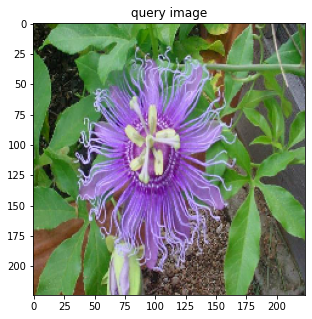

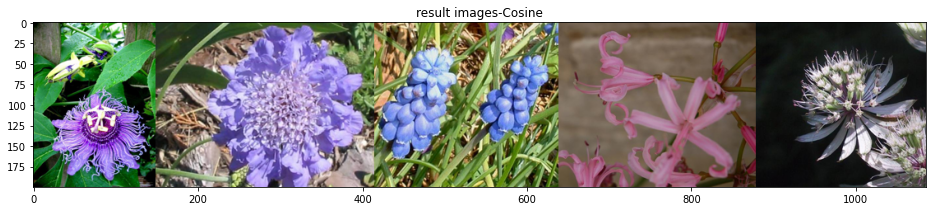

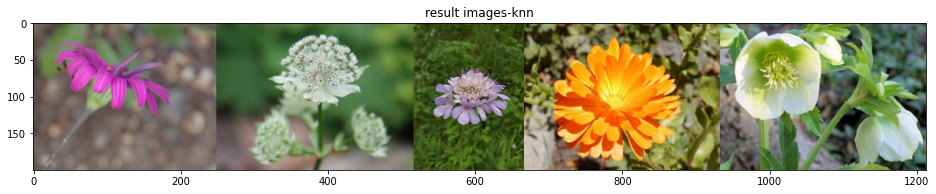

In [11]:
# display the results

plt.figure(figsize = (5,5))
plt.imshow(new_image)
plt.title("query image")
plt.figure(figsize = (16,12))
plt.imshow(results_image_cosine)
plt.title("result images-Cosine")

plt.figure(figsize = (16,12))
plt.imshow(results_image_knn)
plt.title("result images-knn")
